In [23]:
from PIL import Image
import numpy as np
from PIL.ExifTags import TAGS
import os
import matplotlib.pyplot as plt
from scipy import signal
import sympy as sp
import cv2


In [24]:
def ReadImageWithExif(filepath):
    img = Image.open(filepath)
    exif = img._getexif()
    retImg = plt.imread(filepath)
    if retImg.dtype == np.float32:
        retImg = np.uint8(retImg*255)
    if retImg.dtype != np.uint8:
        raise Exception('wrong image data type')
    return (retImg, exif[33434])

In [25]:
def ReadAllImagesInDirectory(directory):
    ret = []
    for filename in sorted(os.listdir(directory)):
        if filename.endswith(".jpg"):
            ret.append(ReadImageWithExif(directory + "/" + filename))
    return ret

In [26]:
def select_pts(im_list, pts=100):
    '''
    Izbere naključne točke v sliki in vrne seznam točk.
    '''
    H, W = im_list[0].shape[:2]
    pts_H = np.random.randint(0, H, size=(pts,))
    pts_W = np.random.randint(0, W, size=(pts,))
    
    pts_list = []
    for im in im_list:
        im_pts_val = im[pts_H, pts_W]
        pts_list.append(im_pts_val)
        
    return pts_list

In [27]:
def estimate_camera_inv_sens_function(pixel_values, exposure_times, welchWindow=None, sWeight = 1, improved = True):
    '''
    Oceni inverzno funkcijo senzitivnosti kamere iz izbranih
    vrednosti slike in časov izpostavitve.
    
    pixel_values - numpy.ndarray, NxM
        N - število slik.
        M - število izbranih točk.
        
        Vsak stolpec predstavlja vrednosti iste točke v različnih
        slikah. Vsaka vrstica predstavlja vrednosti različnih točk
        iz iste slike.
    
    exposure_times - numpy.ndarray, Nx1
        Časi izpostavitve za posamezne slike v vrsticah pixel_values.
    '''
    if pixel_values.ndim != 2:
        raise Exception('Pricakujem 2D podatke - NxM.')
    # N - stevilo slik
    # M - stevilo tock/vrednosti
    N, M = pixel_values.shape
    Z = pixel_values
    _n = 256

    #v zadnjih 254 je dodana še funkcija za glajenje zato naredimo prostor
    A_g = np.zeros((N*M+1+_n-2, 256)) # matrika vrednosti slike, N*M vrednosti iz slik +1 dodaten pogoj
    A_E = np.zeros((N*M+1+_n-2, M)) # matrika tock slike, N*M vrednosti iz slik +1 dodaten pogoj
    B = np.zeros((N*M+1+_n-2, 1)) # vektor casov zajemanja, N*M vrednosti iz slik +1 dodaten pogoj

    for n in range(0, N): # za vsako sliko
        for m in range(0, M): # preko vseh izbranih tock
            if improved:
                A_g[n*M+m, Z[n, m]] = welchWindow[Z[n,m]] #binarni vektor 1 na mestih v in 0 na vseh ostalih (v = z[i,j])
                A_E[n*M+m, m] = -welchWindow[Z[n,m]]
                B[n*M+m]  = np.log(exposure_times[n]) * welchWindow[Z[n,m]]
            else:
                A_g[n*M+m, Z[n, m]] = 1 
                A_E[n*M+m, m] = -1 
                B[n*M+m]  = np.log(exposure_times[n])

    #zaradi dvoumnosti v skaliranju časa in svetlosti dodaten pogoj
    # dodaten pogoj
    # vrednost 128 naj bo enaka 0
    A_g[-1, 128] = 1
    B[-1] = 0
    n += 1
    

    # sestavimo podmatriki A_g (vrednosti slike) in A_E (tocke slike) 
    A = np.hstack((A_g, A_E))
    if improved:
        for i in range(0, _n-3):#here we continue indexing IN NxM row-col (from prev. for loop)
            A[N*M+2+i,i] = -welchWindow[i] * sWeight #as matlab at the end of the pdf shows, except 3rd derivative modification
            A[N*M+2+i,i+1] = 3*welchWindow[i] * sWeight #we also multiply by additional weight (strength of smoothing)
            A[N*M+2+i,i+2] = -3*welchWindow[i] * sWeight
            A[N*M+2+i,i+3] = welchWindow[i] * sWeight

    # resim sistem enacb z lstsq - least squares solver/solution
    #import pdb
    #pdb.set_trace()
    plt.imshow(A)
    X, _, _, _ = np.linalg.lstsq(A, B, rcond=None)
    # izluscim samo koeficiente inverza senzitivne funkcije kamere
    g = X[:256].ravel()
    
    return g

In [28]:
def convert_img_to_log_intensity(img_list, time, inv_sens_function):
    # rekonstrukcija posamezne slike intenzitete E_i
    return [inv_sens_function[im]-np.log(t) for im, t in zip(img_list, time)]

In [29]:
def show_list_of_images(img_list, normalize=False, R=None, C=None, title=None, subtitles=None):
    '''
    Prikaz serije slik v enem oknu.
    
    img_list - list, serija slik
    normalize - bool
        Podane slike se nromalizirajo, tako da se poišče minimalna in
        maksimalna vrednost preko vseh slik. Ti dve se nato uporabita 
        za normalizacijo vsake slike: img=(img-min)/(max-min)
    R - int
    C - int
        Število vrstic (R) in stolpcev (C) za prikaz z pyplot.subplots. V kolikor
        nista podana, sta izračunana tako, da se slike optimalno 
        porazdelijo v oknu.
    
    title - str
        Naslov za celotno okno - figure.suptitle
        
    subtitles - list of str
        Naslov za vsako sliko, prikazani z axes.set_title.
        
    Vrne
        fig, ax_list
        Referenco na figure in axes, kot jih vrne pyplot.subplots.
        Tabela ax_list je preoblikovana - linearizirana.
    '''
    if normalize:
        v_min = np.min(img_list)
        v_max = np.max(img_list)
    else:
        v_min=0
        if img_list[0].dtype== np.uint8:
            v_max=255.
        else:
            v_max = 1
    
    if R is None or C is None:
        R = int(len(img_list)**0.5)
        C = int(np.ceil(len(img_list)/R))
    
    fig, ax_list = plt.subplots(R, C, squeeze=True)
    ax_list = ax_list.reshape(-1)

    for n, img in enumerate(img_list):
        img_norm = (img-v_min)/(v_max-v_min)
        
        ax_list[n].imshow(img_norm)
        ax_list[n].axis('off')
        if subtitles is not None:
            ax_list[n].set_title(subtitles[n])

    for n in range(n+1, len(ax_list)):
        ax_list[n].axis('off')
        
    if title:
        fig.suptitle(title)
    
    return fig, ax_list

In [30]:
def rec_int_image_from_bracketed_list(img_list, time_list, N_pts=100, show_res=True, improved = True):
    welchWindow = GetWelchWindow() #get welch weights for further use
    # rekonstrukcija hdr slike iz serije kadriranih slik
    val_list = select_pts(img_list, N_pts) # get random points
    val_list = np.array(val_list) # convert to numpy array
    val_list = val_list.reshape(len(img_list), N_pts*3) # eno prenosno funkcijo za vse barvne kanale

    cam_inv_sens_fun = estimate_camera_inv_sens_function(val_list, time_list, welchWindow, improved)

    # pretvorba slik iz vrednosti kamere v intenzitete
    img_log_int_list = convert_img_to_log_intensity(img_list, time_list, cam_inv_sens_fun)
    img_int_list = [np.exp(img) for img in img_log_int_list]
    result = None
    if improved:
        result = np.zeros(img_list[0].shape)
        divisor = np.zeros(img_list[0].shape)
        counter = 0
        for image in img_list:
            result += welchWindow[image] * img_log_int_list[counter]
            divisor += welchWindow[image]
            counter += 1

        # rekonstrukcija ene HDR slike
        result = result / divisor
    else:
        result = np.mean(img_log_int_list, 0) # povprečna slika


    img_int = np.exp(result)
    img_int /= img_int.max()

    # prikazi rezultate
    if show_res:        
        img_labels = [f'exp. {t*1e3:.0f} ms' for t in time_list]
        
        
        show_list_of_images([img_int, np.minimum(img_int*8, 1), np.minimum(img_int*16, 1), np.minimum(img_int*32, 1)],
                            title='reconst. hdr slika\n$E_{i,rec}$',
                            subtitles=[f'img*{p}' for p in [1,8,16,32]])
        
        show_list_of_images(img_int_list, normalize=True, 
                            title='slike intenzitete\n$E_i$', subtitles=img_labels)
        
        show_list_of_images(img_log_int_list, normalize=True, 
                            title='slike intenzitete\n$log(E_i)$', subtitles=img_labels)

        plt.figure()
        plt.plot(cam_inv_sens_fun)
        plt.xlabel('vrednost piksla \n$Z_{ij}$')
        plt.ylabel('intenziteta svetlobe \n$E_i \Delta t_j$')
        plt.title('inv. senzitivnost kamere \n$g(v)$')
        
        show_list_of_images(img_list, title='original', subtitles=img_labels)


    return img_int



In [31]:
#https://www.recordingblogs.com/wiki/welch-window
def GetWelchWindow():
    size = 256
    k = np.arange(size)
    welch = (1-((k-((size-1)/2))/((size+1)/2))**2)*size/2 #welch window equation
    plt.figure()
    plt.plot(welch)
    plt.title('welch window')
    plt.show()
    return welch

In [32]:
def Save16BitPNG(img, filename):
    img_16bit = np.uint16(img*65535) #expand to 16 bits
    img_16bit = img_16bit.astype(np.uint16) #convert to uint16
    cv2.imwrite(filename, cv2.cvtColor(img_16bit,cv2.COLOR_RGB2BGR))
    #plt.imsave(filename, img_16bit)

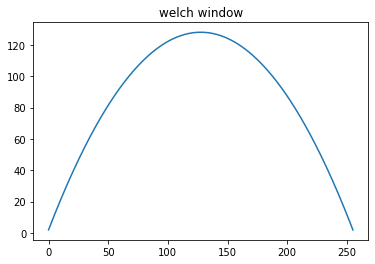

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


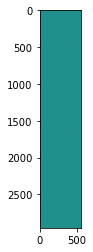

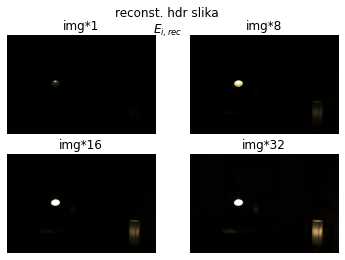

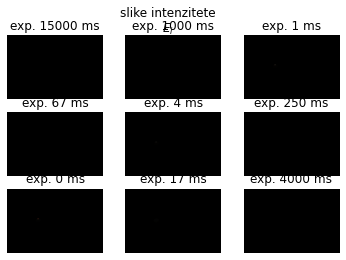

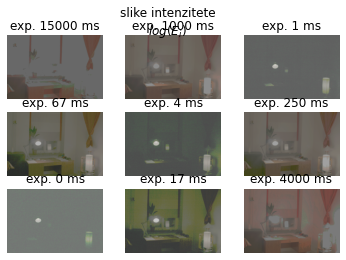

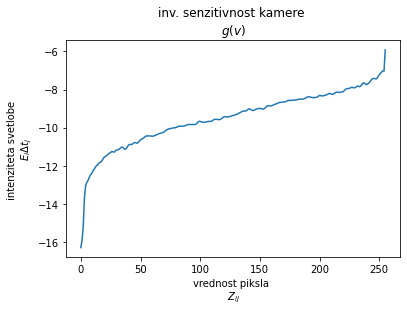

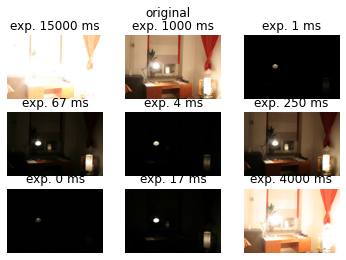

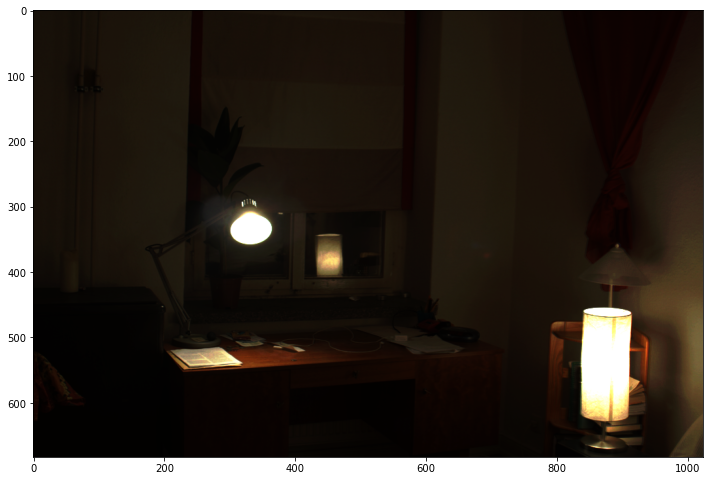

In [33]:
ImagesAndTimes = ReadAllImagesInDirectory("hdr_images_4/slike/pics_window/")
im_list2 = [item[0] for item in ImagesAndTimes]
time_list = np.array([item[1] for item in ImagesAndTimes], dtype=np.float64)
im_hdr = rec_int_image_from_bracketed_list(im_list2, time_list, show_res=True, improved=True)
Save16BitPNG(im_hdr, "result/res.png")
plt.figure(figsize = (12,12))
plt.imshow((im_hdr*300))